# Team Cyberwise
## Cyber Fraud Detection Automata - v2
### (Tailor-made for SMEs, open source, speed + scalability + quality of prediction)

In [2]:
# this algorithm reads in logs files, automates the formatting, 
#classifies behaviors of false alarms vs. real threats, and develops an ML-model for prediction

In [1]:
rm(list=(ls()))
R.version.string

[1] "R version 4.0.2 (2020-06-22)"

In [2]:
install.packages('fastDummies')

Installing package into 'C:/Users/Faiz/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'fastDummies' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Faiz\AppData\Local\Temp\RtmpQXxVKW\downloaded_packages


In [3]:
#used/tobeused packages here
library(tidyverse)
library(ggplot2)
library(fastDummies)
library(e1071)
library(caret)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'fastDummies' was built under R version 4.0.3"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [4]:
# read log
log <- read.csv("logs.csv")

### Data Engineering Steps

In [5]:
#there are some gaps in column 2 (what should be day), need to clean these up - doing in quattro reading in new file

In [6]:
# read log
log1 <- read.csv("logs_clean.csv")

In [7]:
#label the columns better
names(log1) <- c("month", "day", "time", "source", "proxy", "ipaddress","timestamp","public","service","seq1","data1","data2",
                "ignore1","ignore2","label1","seq2","seq3","action","note","http")

In [8]:
unique(log1[["month"]])

[1] "Oct"               "Sep"               "you"              
 [4] ":"                 "fetch"             "1"                
 [7] "'replace-header'," "'sc-inc-gpc0(*)'," "active"           
[10] "backup"            "key"               "from"

In [9]:
oct <- filter(log1, month == "Oct")
sep <- filter(log1, month == "Sep")
other <- filter(log1, month !="Oct", month != "Sep" )

In [10]:
# the 'other' dataset is some notes and does not contain useful ip or web traffice info, will delete it (i.e. only focus on the oct and sep data frames)

In [11]:
#some stats on sep / oct dataset

In [12]:
(unique(sep[["service"]]))

[1] "public/<NOSRV>"    "SSL"               "mail_server/srv01"
[4] "blog_server/srv01" "git_server/srv01"  ":"                
[7] ""                  "in"                "(FE:"

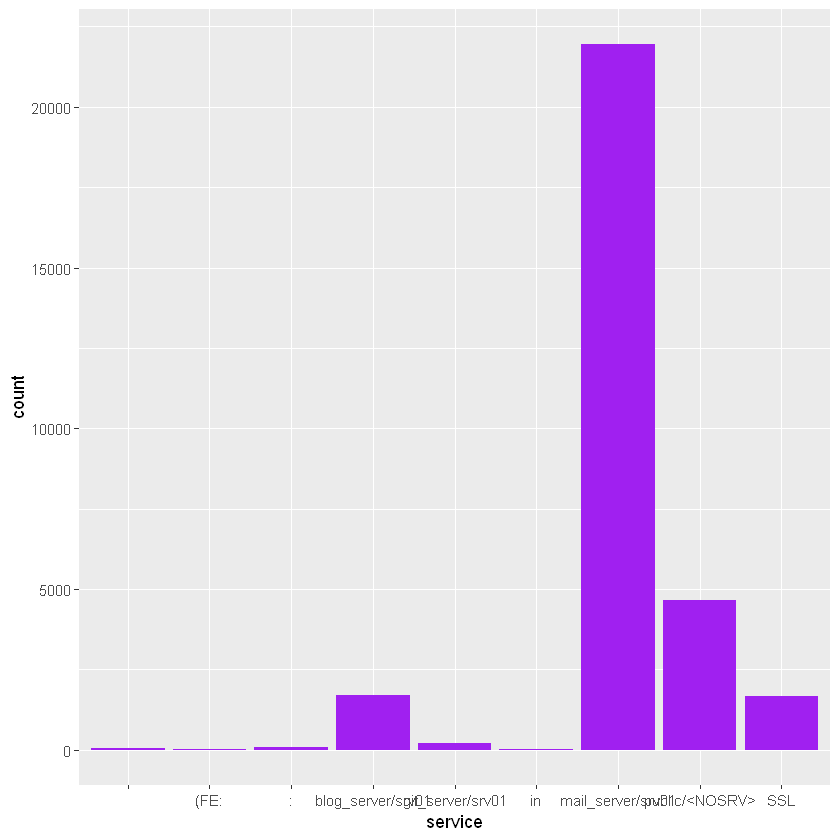

In [13]:
ggplot(data=sep, aes(x=service), options(repr.plot.width=15, repr.plot.height=4)) +
  geom_bar(fill = "purple")

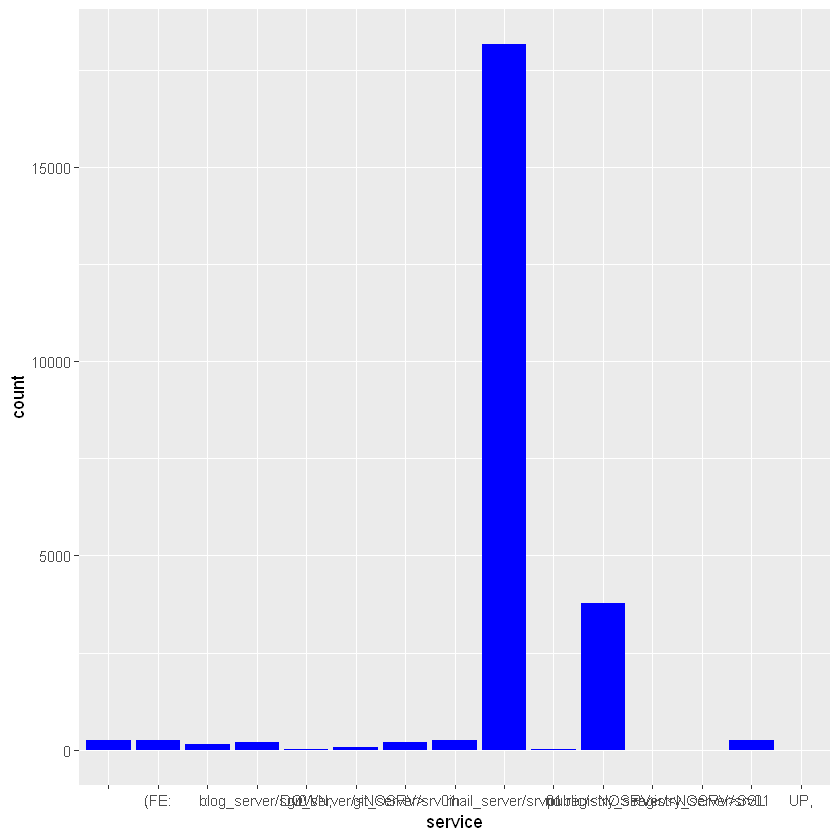

In [14]:
ggplot(data=oct, aes(x=service)) +
  geom_bar(fill = "blue") 

In [16]:
(unique(sep[["action"]]))

[1] "\"GET"              ""                   "\"POST"            
 [4] "\"HEAD"             "<BADREQ>"           "\"SSTP_DUPLEX_POST"
 [7] "\"OPTIONS"          "workload"           "\"CONNECT"         
[10] "load"

In [17]:
(unique(oct[["action"]]))

[1] "\"GET"              "\"POST"             "<BADREQ>"          
 [4] ""                   "\"HEAD"             "workload"          
 [7] "section"            "'http-request"      "auth_okay_admin"   
[10] "referenced"         "\"DELETE"           "'tarpit',"         
[13] "group"              "duration:"          "active"            
[16] "\"OPTIONS"          "\"SSTP_DUPLEX_POST" "HELP"              
[19] "\"CONNECT"

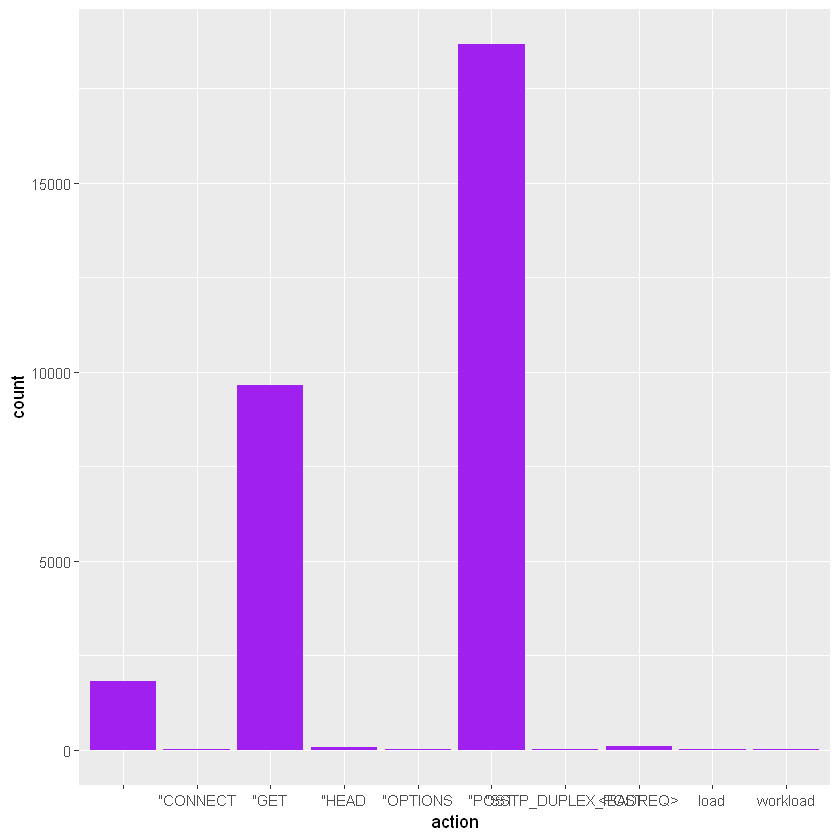

In [18]:
ggplot(data=sep, aes(x=action)) +
  geom_bar(fill = "purple")

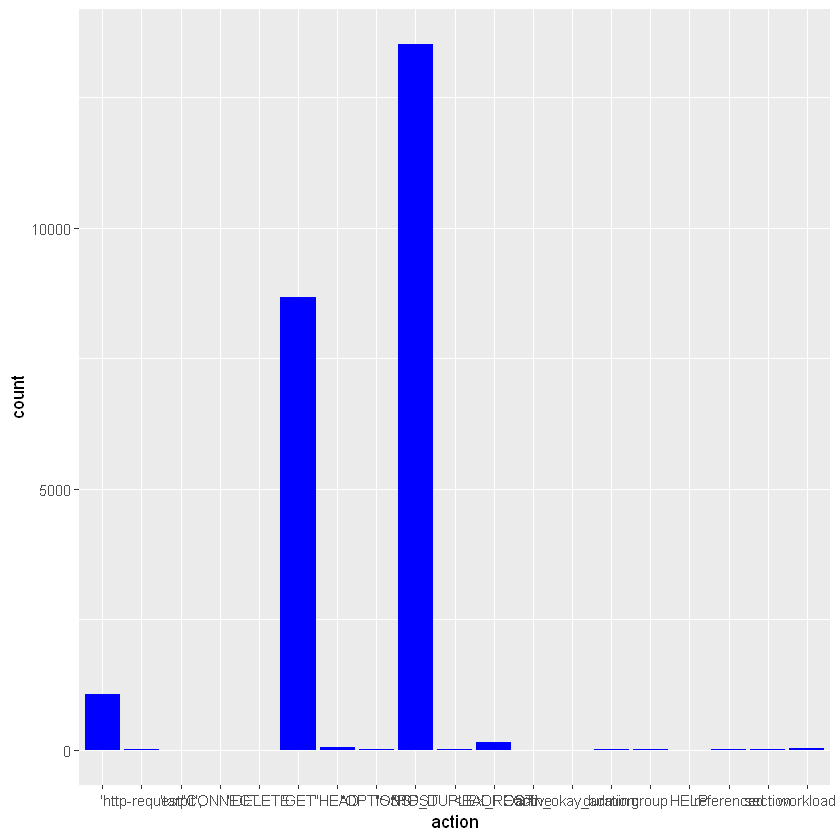

In [19]:
ggplot(data=oct, aes(x=action)) +
  geom_bar(fill = "blue")

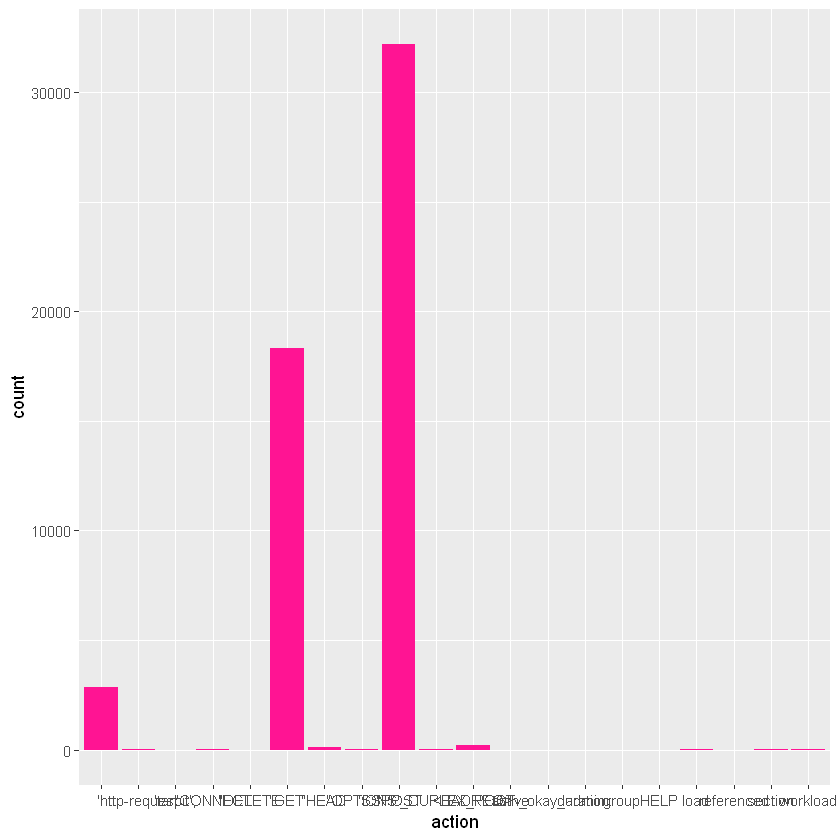

In [20]:
#test for correlations between "service" and "action"
#merge sep and oct
total <- rbind(sep, oct)
ggplot(data=total, aes(x=action)) +
  geom_bar(fill = "deeppink")

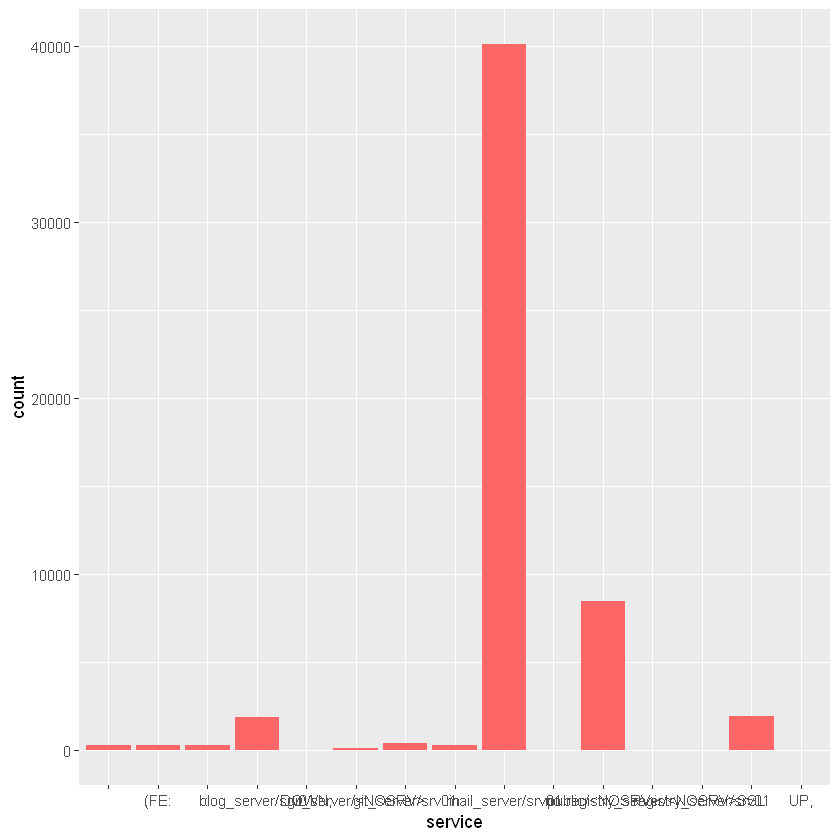

In [21]:
ggplot(data=total, aes(x=service)) +
  geom_bar(fill = "#FF6666")

In [22]:
#for starters, want to predict the public/<NOSRV> - ~7500 of these out of 53874
#the main one is mail service (legit), lets make an algorithm that correctly predicts public/<NOSRV> as the label 1 (realthreat), 
#everything else is 0 (no_threat) - as starting point
(unique(total[["service"]]))

[1] "public/<NOSRV>"          "SSL"                    
 [3] "mail_server/srv01"       "blog_server/srv01"      
 [5] "git_server/srv01"        ":"                      
 [7] ""                        "in"                     
 [9] "(FE:"                    "git_server/<NOSRV>"     
[11] "registry_server/<NOSRV>" "registry_server/srv01"  
[13] "DOWN,"                   "no"                     
[15] "UP,"

In [23]:
#checking for correlation - errors, incorrect, need to come back to this alter after creating dummies

In [26]:
# res <- cor.test(total$action, total$service, method = "pearson")
# res

In [27]:
# chi2 = chisq.test(total$month, total$service)
# c(chi2$statistic, chi2$p.value)

In [28]:
#!!!!!!!!!!!!!!!1come back to correlation testsing!!!!!!!!!!!!!!!!!

### Setup

In [29]:
df <- dummy_cols(total, select_columns = 'service')
#this creates my label column "service_public/<NOSRV>" in df

In [30]:
colnames(df)

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_:"                      
[23] "service_(FE:"                    "service_blog_server/srv01"      
[25] "service_DOWN,"                   "service_git_server/<NOSRV>"     
[27] "service_git_server/srv01"        "service_in"                     
[29] "service_mail_server/srv01"       "service_no"                     
[31] "service_public/<NOSRV>"          "service_registry_server/<NOSRV>"
[33] "service_registry_server/srv01"   "service_SSL"                    
[35] "service_UP,"

In [31]:
colnames(df)[colnames(df) == "service_public/<NOSRV>"] <- "threat"
colnames(df)
#i know have a binary label "threat" - now need a detector/classifier model
#hypothesis #1 - action type, repeated ipaddress, seq1, data1, data2, label1, seq2, seq3  could be correlated to label "threat"

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_:"                      
[23] "service_(FE:"                    "service_blog_server/srv01"      
[25] "service_DOWN,"                   "service_git_server/<NOSRV>"     
[27] "service_git_server/srv01"        "service_in"                     
[29] "service_mail_server/srv01"       "service_no"                     
[31] "threat"                          "service_registry_server/<NOSRV>"
[33] "service_registry_server/srv01"   "service_SSL"                    
[35] "service_UP,"

In [33]:
#for purposes of DEMO, we will skip the detailed stat testing to eliminate variables and solidify model.  
#hypthosis # 2 - we we say out top features are action, seq1, data1, and data2 - along any repeated ipaddresses.  
#lets at least check for freq of unique ipaddresses b4 modeling

In [34]:
length(unique(df[["ipaddress"]]))
#out of ~53K total, only 44K ipaddresses are unique
#~10K are used repeatedly, lets check for the high-runners


[1] 44739

In [35]:
df <- transform(df, freq= ave(seq(nrow(df)), ipaddress, FUN=length))
df[order(-df$freq), ]
#!!!!Note - revist this!!!!

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,⋯,service_git_server.srv01,service_in,service_mail_server.srv01,service_no,threat,service_registry_server..NOSRV.,service_registry_server.srv01,service_SSL,service_UP.,freq
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8018,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,public,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8019,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,public,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8020,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,mail_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8021,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,mail_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8022,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,git_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8023,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,git_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8024,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,blog_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8025,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,blog_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8034,Sep,27,6:21:39 AM,cyberwise,haproxy[18755]:,Proxy,public,stopped,(FE:,21621,⋯,0,0,0,0,0,0,0,0,0,532


In [36]:
count(df,ipaddress)

ipaddress,n
<chr>,<int>
[ALERT],148
[WARNING],102
1.193.177.125:4213,1
1.196.79.43:7222,1
1.199.152.182:5048,1
1.55.215.30:43806,1
1.55.215.30:43982,1
1.55.215.30:44132,1
1.68.220.27:11552,1


In [37]:
# want to filter the ipadress field to only include the backend, Proxy, Server, Stopping, [Alert], and [Warning] - 
# - then create dummies for just these

In [38]:
df1 <- filter(df, ipaddress == "Proxy")
df2 <- filter(df, ipaddress == "backend")
df3 <- filter(df, ipaddress == "Server")
df4 <- filter(df, ipaddress == "Stopping")
df5 <- filter(df, ipaddress == "[Alert]")
df6 <- filter(df, ipaddress == "[Warning]")
#| ipaddress = "backend") #, ipaddress == "backend")
#sep <- filter(log1, month == "Sep")
#other <- filter(log1, month !="Oct", month != "Sep" )
new <- rbind(df1, df2, df3, df4, df5, df6)

In [40]:
(unique(new[["action"]]))

[1] ""          "duration:" "active"

In [53]:
# interesting, so this means that after filtering out some of the ipaddresses, the standard actions are no longer present.
# indicates cross-correlation , lets also check threat column

In [41]:
(unique(new[["threat"]]))
#ok, interesting, also indicates that filterting out some of the ipaddresses, i have also found correlattion to my "threat" label.
#since i combined df1 - df6 all together to form 'new', i can check everthing !"new", and remove ipaddress column.
# only focus on rules 9i.e. in notes, response, response code, etc.

[1] 0

In [43]:
df7 <- filter(df, ipaddress != "Proxy")
df7 <- filter(df7, ipaddress != "backend")
df7 <- filter(df7, ipaddress != "Server")
df7 <- filter(df7, ipaddress != "Stopping")
df7 <- filter(df7, ipaddress != "[Alert]")
df7 <- filter(df7, ipaddress != "[Warning]")

In [44]:
(unique(df7[["action"]]))

[1] "\"GET"              ""                   "\"POST"            
 [4] "\"HEAD"             "<BADREQ>"           "\"SSTP_DUPLEX_POST"
 [7] "\"OPTIONS"          "workload"           "\"CONNECT"         
[10] "load"               "section"            "'http-request"     
[13] "auth_okay_admin"    "referenced"         "\"DELETE"          
[16] "'tarpit',"          "group"              "HELP"

In [45]:
(unique(df7[["threat"]]))

[1] 1 0

In [46]:
count(df7,threat)

threat,n
<int>,<int>
0,44649
1,8429


In [47]:
# simplify the input data
colnames(df7)

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_."                      
[23] "service_.FE."                    "service_blog_server.srv01"      
[25] "service_DOWN."                   "service_git_server..NOSRV."     
[27] "service_git_server.srv01"        "service_in"                     
[29] "service_mail_server.srv01"       "service_no"                     
[31] "threat"                          "service_registry_server..NOSRV."
[33] "service_registry_server.srv01"   "service_SSL"                    
[35] "service_UP."                     "freq"

In [48]:
# remove unused columns
df8 <- subset(df7, select = -c(1,2,3,4,5,6,7,8,9,13,14,21:30,32:37 ) )
colnames(df8)

[1] "seq1"   "data1"  "data2"  "label1" "seq2"   "seq3"   "action" "note"  
 [9] "http"   "threat"

In [49]:
# create dummies on (seq1, data1, data2, label1, seq2, seq3), just start with "action" 
dummy <- dummy_cols(df8, select_columns = 'action')
colnames(dummy)

[1] "seq1"                      "data1"                    
 [3] "data2"                     "label1"                   
 [5] "seq2"                      "seq3"                     
 [7] "action"                    "note"                     
 [9] "http"                      "threat"                   
[11] "action_"                   "action_'http-request"     
[13] "action_'tarpit',"          "action_\"CONNECT"         
[15] "action_\"DELETE"           "action_\"GET"             
[17] "action_\"HEAD"             "action_\"OPTIONS"         
[19] "action_\"POST"             "action_\"SSTP_DUPLEX_POST"
[21] "action_<BADREQ>"           "action_auth_okay_admin"   
[23] "action_group"              "action_HELP"              
[25] "action_load"               "action_referenced"        
[27] "action_section"            "action_workload"

In [50]:
# create input of just action variables
input <- subset(dummy, select = -c(1:9))
colnames(input)

[1] "threat"                    "action_"                  
 [3] "action_'http-request"      "action_'tarpit',"         
 [5] "action_\"CONNECT"          "action_\"DELETE"          
 [7] "action_\"GET"              "action_\"HEAD"            
 [9] "action_\"OPTIONS"          "action_\"POST"            
[11] "action_\"SSTP_DUPLEX_POST" "action_<BADREQ>"          
[13] "action_auth_okay_admin"    "action_group"             
[15] "action_HELP"               "action_load"              
[17] "action_referenced"         "action_section"           
[19] "action_workload"

In [51]:
# rules to focus on:
# Request for some .php file in wp which got error code as a response (e.G. uri="/new/wp-admin/install.php?step=1")
# Path traversal in uri (e.G. uri="/wp-content/plugins/image-export/download.php?file=../../../wp-config.php")

# GET reqeust some .php file in wp which got error code as a response
# Path traversal in uri
# POST request without 200 response code
# can assume all NOSRV line are bad

### Modeling (choice of final algo TBD, binary classification with a few features, so will try SVM algo first)

In [52]:
set.seed(555)

In [53]:
# test train split
data1 = sort(sample(nrow(input), nrow(input)*.7))

#creating training data set by selecting the output row values
train<-input[data1,]

#creating test data set by not selecting the output row values
test<-input[-data1,]

In [61]:
x <- subset(train, select = -threat)
y <- subset(train, select = threat)
testx <- subset(test, select = -threat)
testy <- subset(test, select = threat)

In [62]:
model <- svm(x, y)

In [ ]:
# model1 <- svm(y ~ x, data= mtcars[train, ], kernel = "radial", gamma =1, cost =1)

In [63]:
print(model)


Call:
svm.default(x = x, y = y)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05555556 
    epsilon:  0.1 


Number of Support Vectors:  11258



In [64]:
summary(model)


Call:
svm.default(x = x, y = y)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05555556 
    epsilon:  0.1 


Number of Support Vectors:  11258






### Prediction

In [71]:
# test with test data
pred = predict(model, test)

ERROR: Error in scale.default(newdata[, object$scaled, drop = FALSE], center = object$x.scale$"scaled:center", : length of 'center' must equal the number of columns of 'x'


In [72]:
#FORECAST and COMPARISION TO TRUTH
pred = predict(model, newdata=test)
#true = bike[-train, "holiday"]
#confusion matrix/test error
#table(true, pred)
#caret::confusionMatrix(pred, true)

ERROR: Error in scale.default(newdata[, object$scaled, drop = FALSE], center = object$x.scale$"scaled:center", : length of 'center' must equal the number of columns of 'x'


### Validation

In [68]:
# Check accuracy:
tab1 <- table(testy, pred)
#confusionMatrix(tab1)

ERROR: Error in table(testy, pred): all arguments must have the same length


### Final Prep / Deployment